In this notebook we are testing that the `ImageClassificationDataset` and `DataLoader`are working properly. We are also experimenting a little with RandAugment ― reusing the neat implementation by [Adam Mehdi](https://github.com/adam-mehdi/MuarAugment).

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import albumentations
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torchvision.utils as utils
from albumentations.pytorch import transforms
from omegaconf import OmegaConf

from ml.vision.augmentations import BatchRandAugment
from ml.vision.data import ImageDataModule
from ml.vision.utils import plot_batches

In [3]:
df = pd.read_csv("../data/train_folds.csv")
df['fpath'] = "../data/train_224/" + df.Id + ".jpg"
df.head()

Unnamed: 0                                Id  Subject Focus  Eyes  Face  \
0           0  0007de18844b0dbbb5e1f607da0606e0              0     1     1   
1           1  0009c66b9439883ba2750fb825e1d7db              0     1     1   
2           2  0013fd999caf9a3efe1352ca1b0d937e              0     1     1   
3           3  0018df346ac9c1d8413cfcc888ca8246              0     1     1   
4           4  001dc955e10590d3ca4673f034feeef2              0     0     0   

   Near  Action  Accessory  Group  Collage  Human  Occlusion  Info  Blur  \
0     1       0          0      1        0      0          0     0     0   
1     0       0          0      0        0      0          0     0     0   
2     1       0          0      0        0      1          1     0     0   
3     1       0          0      0        0      0          0     0     0   
4     1       0          0      1        0      0          0     0     0   

   Pawpularity  kfold                                              fpath  
0           63      2  ../data/train_224/0007de18844b0dbbb5e1f607da06...  
1           42      0  ../data/train_224/0009c66b9439883ba2750fb825e1...  
2           28      4  ../data/train_224/0013fd999caf9a3efe1352ca1b0d...  
3           15      2  ../data/train_224/0018df346ac9c1d8413cfcc888ca...  
4           72      3  ../data/train_224/001dc955e10590d3ca4673f034fe...

## Without RandAugment

In [4]:
train_image_fpaths = df.fpath.values.tolist()
train_image_fpaths[:5]

['../data/train_224/0007de18844b0dbbb5e1f607da0606e0.jpg',
 '../data/train_224/0009c66b9439883ba2750fb825e1d7db.jpg',
 '../data/train_224/0013fd999caf9a3efe1352ca1b0d937e.jpg',
 '../data/train_224/0018df346ac9c1d8413cfcc888ca8246.jpg',
 '../data/train_224/001dc955e10590d3ca4673f034feeef2.jpg']

In [5]:
dm = ImageDataModule(
    task="classification",
    batch_size=32,
    train_image_paths=train_image_fpaths[:32],
    train_targets=df.Pawpularity.values,
)
dm.setup()

In [6]:
dl = dm.train_dataloader()

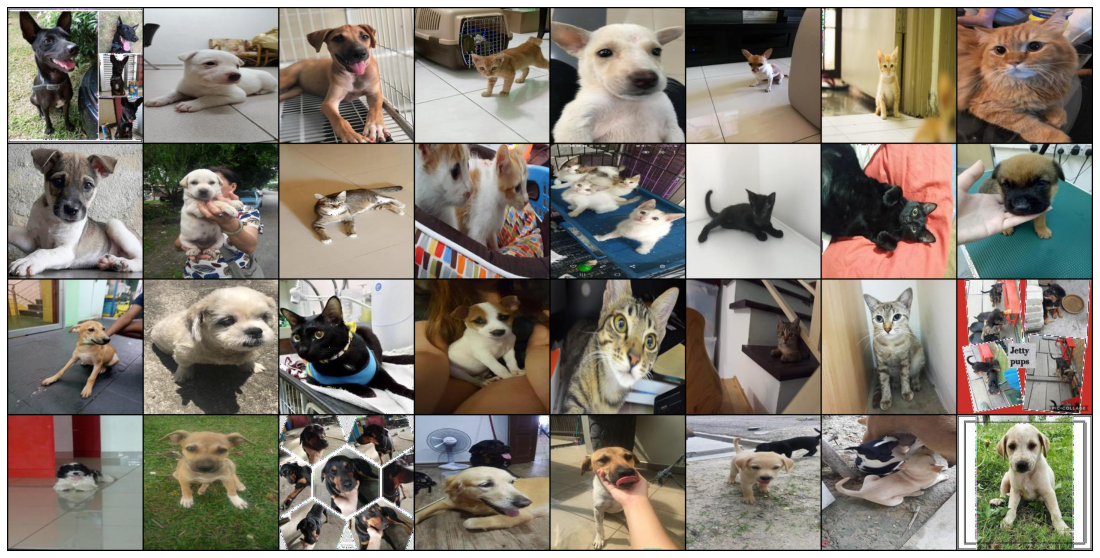

In [7]:
plot_batches(dl, 1)

What causes the images to be mostly white? Look into `plot_batches()`.

## With RandomResizedCrop

In [8]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [9]:
cfg = OmegaConf.create(dict(
    n_tfms=4,
    magn=8,
    mean=mean,
    std=std,
    sz=224
))

In [10]:
augmentations = BatchRandAugment(
    0,
    0,
    mean=cfg.mean,
    std=cfg.std,
    use_normalize=False,
    use_resize=0,
    image_size=(cfg.sz, cfg.sz),
)

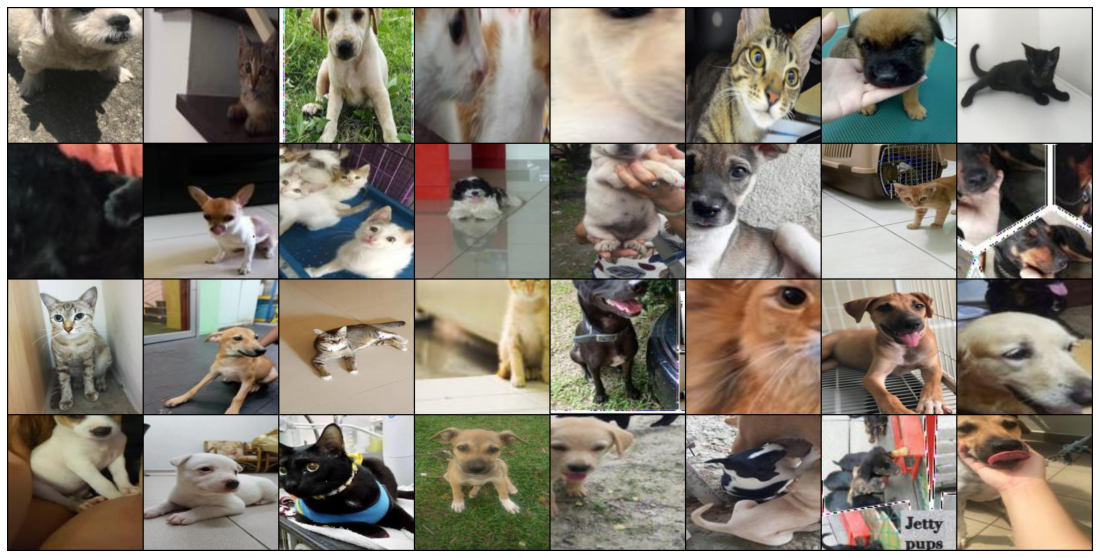

In [11]:
plt.figure(figsize=(20, 10))
for batch in dl:
    images, targets = batch
    
    augmentations.setup()
    images = augmentations(images)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break
plt.axis("off")
plt.ioff()
plt.show()

## With RandAugment

In [12]:
augmentations = BatchRandAugment(
    cfg.n_tfms,
    cfg.magn,
    mean=cfg.mean,
    std=cfg.std,
    use_normalize=False,
)

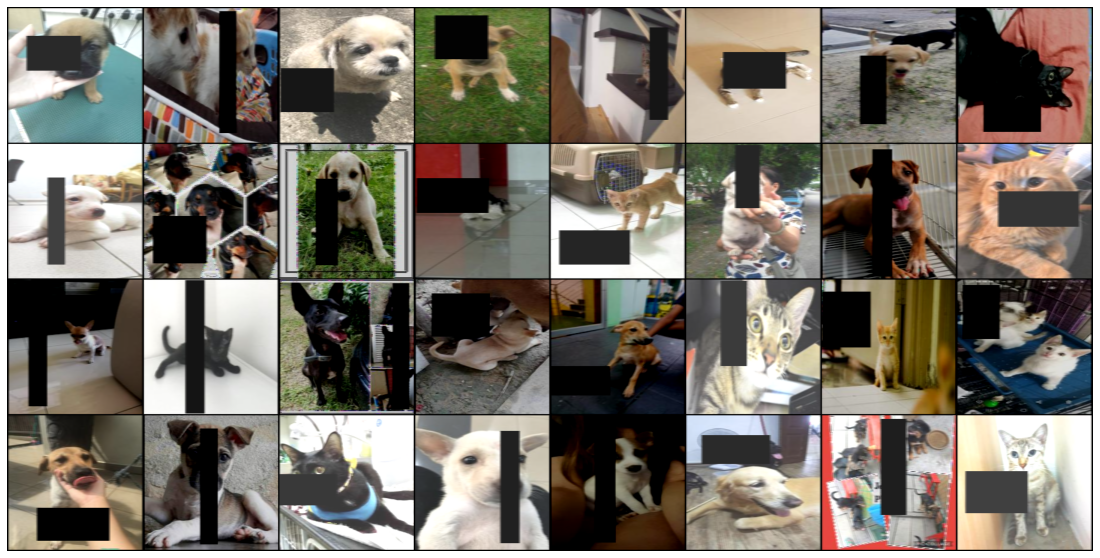

In [13]:
plt.figure(figsize=(20, 10))
for batch in dl:
    images, targets = batch
    
    augmentations.setup()
    images = augmentations(images)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break
plt.axis("off")
plt.ioff()
plt.show()

In [14]:
augmentations

BatchRandAugment(
  (transform): Sequential(
    (0): RandomErasing(scale=(0.08, 0.16), ratio=(0.4, 8), value=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (1): ColorJitter(brightness=0.0, contrast=0.0, saturation=0.26666666666666666, hue=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (2): RandomMotionBlur(kernel_size=5, angle=8, direction=1.0, border_type='constant', p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (3): ColorJitter(brightness=0.26666666666666666, contrast=0.0, saturation=0.0, hue=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
  )
)

## With MixUp & CutMix

In [15]:
augmentations = BatchRandAugment(
    0,
    0,
    mean=cfg.mean,
    std=cfg.std,
    use_normalize=False,
    image_size=(cfg.sz, cfg.sz),
    use_mix=1,
    mix_p=1.
)

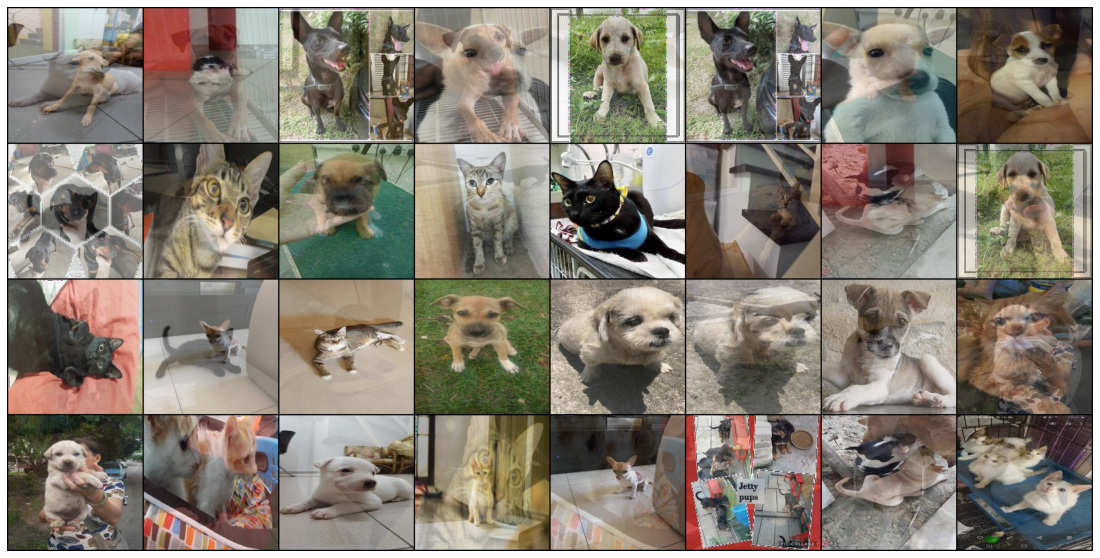

In [16]:
plt.figure(figsize=(20, 10))
for batch in dl:
    images, targets = batch
    
    augmentations.setup()
    images, targets = augmentations(images, targets)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break
plt.axis("off")
plt.ioff()
plt.show()

In [17]:
torch.set_printoptions(sci_mode=False)
targets

tensor([[ 15.0000,  15.0000,   0.4492],
        [ 31.0000,  74.0000,   0.7683],
        [ 40.0000,  29.0000,   0.7056],
        [ 50.0000,  31.0000,   0.4250],
        [ 29.0000,  34.0000,   0.7925],
        [ 29.0000,  36.0000,   0.2716],
        [ 28.0000,  50.0000,   0.6556],
        [ 53.0000,   2.0000,   0.7827],
        [ 69.0000,  34.0000,   0.4799],
        [ 22.0000,  21.0000,   0.7010],
        [ 21.0000,  28.0000,   0.5825],
        [ 28.0000,  63.0000,   0.2096],
        [ 13.0000,  13.0000,   0.5277],
        [ 15.0000,  42.0000,   0.8273],
        [ 74.0000,  72.0000,   0.5337],
        [ 34.0000,  22.0000,   0.4466],
        [ 28.0000,  28.0000,   0.2608],
        [ 34.0000, 100.0000,   0.5191],
        [ 18.0000,  53.0000,   0.1095],
        [ 35.0000,  21.0000,   0.9382],
        [ 98.0000,  29.0000,   0.1061],
        [ 63.0000,  98.0000,   0.5786],
        [ 36.0000,  18.0000,   0.3066],
        [ 53.0000,  41.0000,   0.4012],
        [ 41.0000,  53.0000,   0.1905],


## Mixing it all together

In [18]:
augmentations = BatchRandAugment(
    cfg.n_tfms,
    cfg.magn,
    mean=cfg.mean,
    std=cfg.std,
    use_normalize=False,
    image_size=(cfg.sz, cfg.sz),
    use_mix=1,
    mix_p=0.25,
)

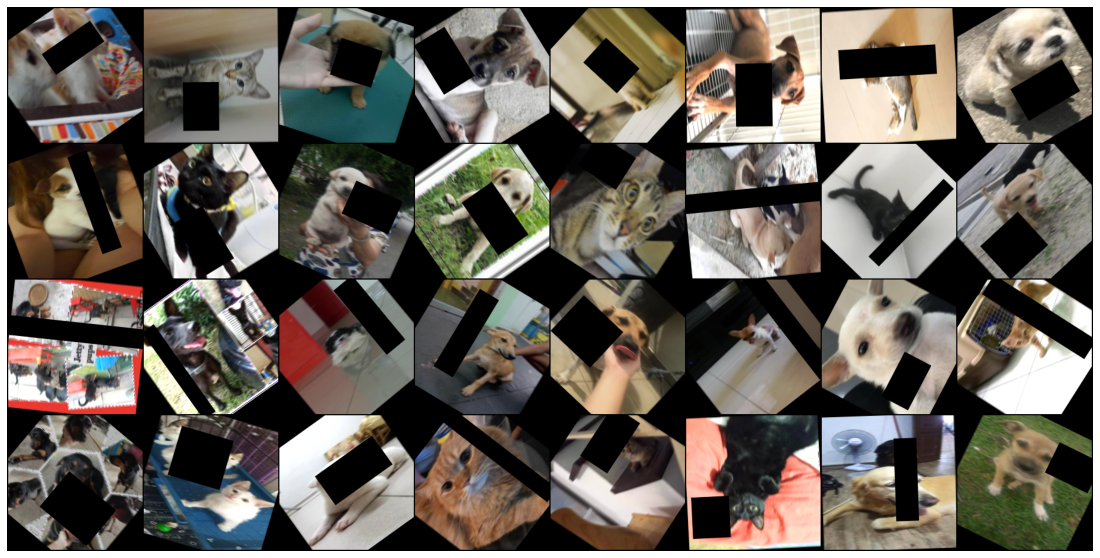

In [19]:
plt.figure(figsize=(20, 10))
for batch in dl:
    images, targets = batch
    
    augmentations.setup()
    images, targets = augmentations(images, targets)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break
plt.axis("off")
plt.ioff()
plt.show()

In [20]:
augmentations

BatchRandAugment(
  (transform): Sequential(
    (0): RandomMotionBlur(kernel_size=5, angle=8, direction=1.0, border_type='constant', p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (1): RandomErasing(scale=(0.08, 0.16), ratio=(0.4, 8), value=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (2): RandomRotation(degrees=90.0, interpolation=BILINEAR, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (3): ColorJitter(brightness=0.0, contrast=0.26666666666666666, saturation=0.0, hue=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
  )
)

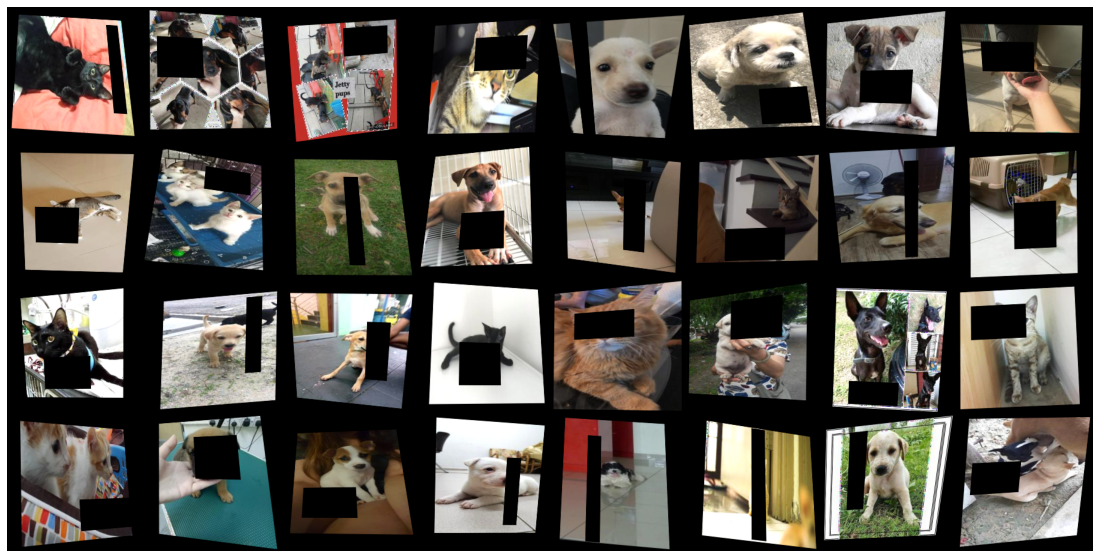

In [21]:
plt.figure(figsize=(20, 10))
for batch in dl:
    images, targets = batch
    
    augmentations.setup()
    images, targets = augmentations(images, targets)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break
plt.axis("off")
plt.ioff()
plt.show()

In [22]:
augmentations

BatchRandAugment(
  (transform): Sequential(
    (0): RandomErasing(scale=(0.08, 0.16), ratio=(0.4, 8), value=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (1): ColorJitter(brightness=0.0, contrast=0.0, saturation=0.0, hue=0.0, p=0, p_batch=1.0, same_on_batch=False, return_transform=False)
    (2): ColorJitter(brightness=0.0, contrast=0.26666666666666666, saturation=0.0, hue=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (3): RandomPerspective(distortion_scale=0.32, interpolation=BILINEAR, align_corners=False, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
  )
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


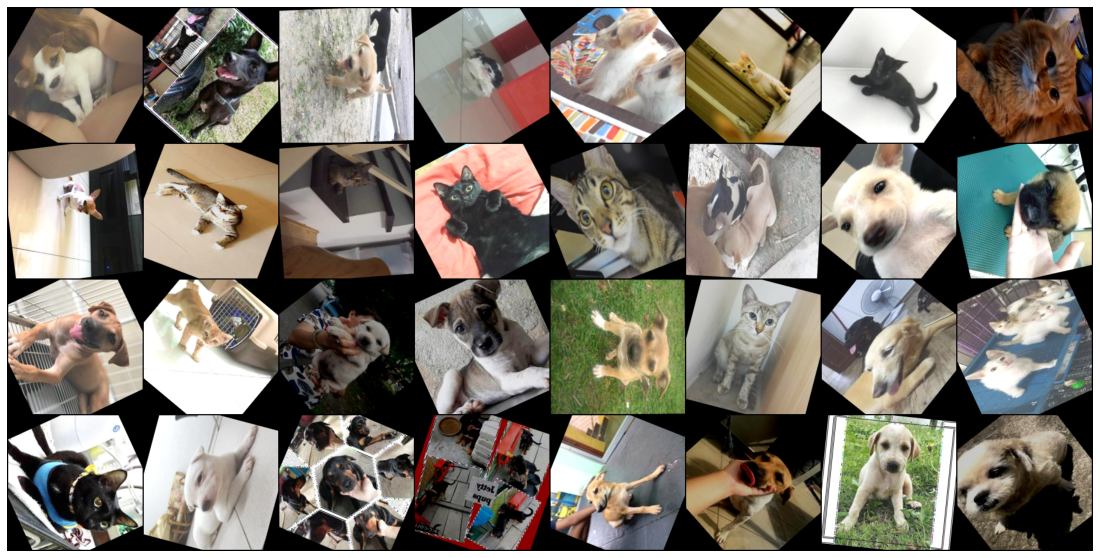

In [23]:
plt.figure(figsize=(20, 10))
for batch in dl:
    images, targets = batch
    
    augmentations.setup()
    images, targets = augmentations(images, targets)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break
plt.axis("off")
plt.ioff()
plt.show()

In [24]:
augmentations

BatchRandAugment(
  (transform): Sequential(
    (0): ColorJitter(brightness=0.0, contrast=0.26666666666666666, saturation=0.0, hue=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (1): ColorJitter(brightness=0.26666666666666666, contrast=0.0, saturation=0.0, hue=0.0, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (2): RandomRotation(degrees=90.0, interpolation=BILINEAR, p=1, p_batch=1.0, same_on_batch=False, return_transform=False)
    (3): RandomHorizontalFlip(p=1, p_batch=1.0, same_on_batch=False, return_transform=None)
  )
)

## Use normalization

In [25]:
augmentations = BatchRandAugment(
    cfg.n_tfms,
    cfg.magn,
    mean=cfg.mean,
    std=cfg.std,
    use_normalize=True,
    image_size=(cfg.sz, cfg.sz),
    use_mix=1,
    mix_p=0.25,
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


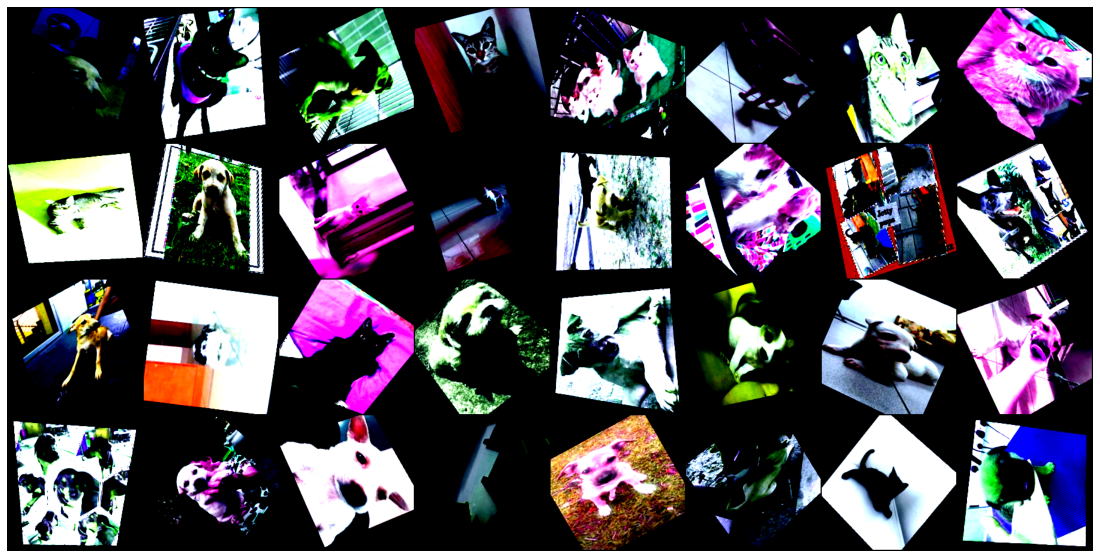

In [26]:
plt.figure(figsize=(20, 10))
for batch in dl:
    images, targets = batch
    
    augmentations.setup()
    images, targets = augmentations(images, targets)

    grid = utils.make_grid(images)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    break
plt.axis("off")
plt.ioff()
plt.show()